
# Word2Vec: Vanilla vs RSR (Human Behavioral Similarity)

## Experiment Pipeline

**Goal**: Compare two Word2Vec models on semantic similarity:
1. **Vanilla**: Trained ONLY on Wikipedia corpus
2. **RSR**: Trained on Wikipedia + Human similarity judgments (4.7M triplets)

### Pipeline Steps:
1. Load Wikipedia corpus
2. Load human behavioral similarity matrix (THINGS dataset)
3. Load THINGS concepts
4. Train Word2Vec **VANILLA** (Wikipedia only)
5. Train Word2Vec **RSR** (Wikipedia + human similarity)
6. Evaluate both on **SimLex-999** benchmark (human similarity ratings)

### RSR Approach (with Tied Embeddings for Generalization)

The RSR model uses **Representational Similarity Regularization** with a key architectural change to enable generalization:

**Architecture: TIED EMBEDDINGS**
- Uses the **same embedding matrix** for both target and context words
- This allows RSR training on THINGS concepts to **propagate to other words**:
  - When non-THINGS words co-occur with THINGS concepts in the corpus
  - The W2V gradients flow through the shared embedding
  - RSR moves THINGS embeddings → non-THINGS neighbors get pulled along

**Loss Function:**
- `L_w2v`: Standard skip-gram on full corpus (any words)
- `L_rsr`: Soft Spearman correlation on THINGS concepts (separate batches)
  - `L_rsr = 1 - soft_spearman(model_similarity, target_similarity)`
- `L_total = (1 - α) × L_w2v + α × L_rsr` where `α = REG_STRENGTH` (default: 0.1)

**Why Tied Embeddings Enable Generalization:**
- Without tying: RSR only updates THINGS target embeddings; non-THINGS words unchanged
- With tying: RSR updates flow to all words that co-occur with THINGS concepts

### Evaluation: SimLex-999 Benchmark

We evaluate using **SimLex-999**, a gold-standard benchmark for semantic similarity (not relatedness). 

To test generalization, we split word pairs into three categories:
- **Both in THINGS**: Both words were used during RSR training → tests direct learning
- **One in THINGS**: Only one word was used → tests partial transfer
- **Neither in THINGS**: Neither word was used → tests true generalization



## Step 1: Imports & Configuration

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import scipy.io as sio

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Note: torchsort is the brain_chapter's choice, but it requires C++ compilation.
# We use a pure PyTorch soft ranking implementation instead (see soft_rank below).

# Configuration
BASE_DATA_DIR = "data"
THINGS_DIR = "things_similarity"

# Corpus path (text file, one sentence per line)
CORPUS_PATH = os.path.join(BASE_DATA_DIR, "AllCombined.txt")

# THINGS paths
THINGS_WORDS_PATH = os.path.join(THINGS_DIR, "variables", "unique_id.txt")
BEHAVIORAL_SIM_PATH = os.path.join(THINGS_DIR, "data", "spose_similarity.mat")
# Try category_mat_manual.mat which likely has the manual category labels
CATEGORY_DATA_PATH = os.path.join(THINGS_DIR, "data", "category_mat_manual.mat")

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


## Step 2: Load Wikipedia Corpus

In [2]:
# Load Wikipedia corpus from text file
print("="*70)
print("STEP 2: Loading Wikipedia Corpus")
print("="*70)

import re
from pathlib import Path

def simple_tokenize(text: str):
    """Basic tokenizer: lowercase, keep only alphabetic characters and spaces, split on whitespace."""
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    return text.split()

def load_corpus(corpus_path: Path):
    """Load corpus as list of token lists (one per line)."""
    sentences = []
    with corpus_path.open("r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            tokens = simple_tokenize(line)
            if tokens:
                sentences.append(tokens)
    return sentences

corpus_path = Path(CORPUS_PATH)
sentences = load_corpus(corpus_path)

print(f"  Source: Wikipedia corpus (AllCombined.txt)")
print(f"  Sentences: {len(sentences):,}")
if sentences:
    print(f"  Sample: {sentences[0][:10]}...")

STEP 2: Loading Wikipedia Corpus
  Source: Wikipedia corpus (AllCombined.txt)
  Sentences: 965,517
  Sample: ['april']...


## Step 3: Load Human Behavioral Similarity Matrix

In [3]:
print("="*70)
print("STEP 3: Loading Human Behavioral Similarity Matrix")
print("="*70)

# Load full behavioral similarity matrix (1854 x 1854 THINGS concepts)
behav_data = sio.loadmat(BEHAVIORAL_SIM_PATH)
behav_sim_full = behav_data['spose_sim']

print(f"  Source: 4.7 million human triplet judgments")
print(f"  Matrix shape: {behav_sim_full.shape}")
print(f"  Similarity range: [{behav_sim_full.min():.3f}, {behav_sim_full.max():.3f}]")
print(f"  Mean similarity: {behav_sim_full.mean():.3f}")

STEP 3: Loading Human Behavioral Similarity Matrix
  Source: 4.7 million human triplet judgments
  Matrix shape: (1854, 1854)
  Similarity range: [0.052, 1.000]
  Mean similarity: 0.334


## Step 4: Load THINGS Concepts & Category Labels

In [4]:
print("="*70)
print("STEP 4: Loading THINGS Concepts & Category Labels")
print("="*70)

# -------------------------
# Reproducibility
# -------------------------
import random
import numpy as np
import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"  Random seed set to {SEED}")

# -------------------------
# Load THINGS concepts
# -------------------------
def load_things_words(words_path):
    """Load THINGS word list (one word per line)."""
    words = []
    with open(words_path, "r", encoding="utf-8") as f:
        for line in f:
            word = line.strip()
            if word:
                words.append(word)
    return words

concepts = load_things_words(THINGS_WORDS_PATH)
print(f"  THINGS concepts: {len(concepts)}")

# -------------------------
# Load Category27 labels (.mat)
# -------------------------
if not os.path.exists(CATEGORY_DATA_PATH):
    raise FileNotFoundError(
        f"[ERROR] Category file not found: {CATEGORY_DATA_PATH}"
    )

category_data = sio.loadmat(CATEGORY_DATA_PATH)

# Debug: show keys and shapes
print("  Category .mat file keys:")
for key in category_data.keys():
    if not key.startswith("__"):
        val = category_data[key]
        if isinstance(val, np.ndarray):
            print(f"    {key}: shape={val.shape}, dtype={val.dtype}")
        else:
            print(f"    {key}: type={type(val)}")

# -------------------------
# Load the correct matrix (STRICT)
# -------------------------
if "category_mat_manual" not in category_data:
    raise KeyError(
        "[ERROR] Missing key 'category_mat_manual' in category .mat file.\n"
        f"Available keys: {list(category_data.keys())}"
    )

Y_all = category_data["category_mat_manual"].astype(np.float32)

# -------------------------
# Shape sanity checks
# -------------------------
if Y_all.ndim != 2:
    raise ValueError(
        f"[ERROR] category_mat_manual must be 2D, got shape {Y_all.shape}"
    )

# Transpose if needed (expect concepts x categories)
if Y_all.shape[0] == 27 and Y_all.shape[1] > 27:
    print(f"  Transposing category matrix from {Y_all.shape} to {Y_all.T.shape}")
    Y_all = Y_all.T

print(f"  Category labels shape: {Y_all.shape}")

# -------------------------
# Alignment warning (no dummy data)
# -------------------------
if Y_all.shape[0] != len(concepts):
    print("  WARNING: Number of category rows does NOT match number of THINGS concepts.")
    print(f"           category rows = {Y_all.shape[0]}")
    print(f"           concepts      = {len(concepts)}")
    print("  WARNING: Assuming row order already matches THINGS word list.")
    print("           If this assumption is wrong, downstream evaluation may be invalid.")

# -------------------------
# Property ratings placeholder (explicit)
# -------------------------
prop_df = pd.DataFrame(index=concepts)
print("  Note: Property ratings not loaded (concept index only)")


STEP 4: Loading THINGS Concepts & Category Labels
  Random seed set to 42
  THINGS concepts: 1854
  Category .mat file keys:
    category_mat_manual: shape=(1854, 27), dtype=uint8
  Category labels shape: (1854, 27)
  Note: Property ratings not loaded (concept index only)


## Step 5: Build Vocabulary & Align Data

In [5]:
print("="*70)
print("STEP 5: Building Vocabulary & Aligning Data")
print("="*70)

# Build vocabulary from corpus
MIN_COUNT = 5
print(f"\nBuilding vocabulary (min_count={MIN_COUNT})...")

word_counts = Counter()
for sent in tqdm(sentences, desc="Counting words"):
    word_counts.update(sent)

vocab = sorted([w for w, c in word_counts.items() if c >= MIN_COUNT])
word2idx = {w: i for i, w in enumerate(vocab)}
idx2word = {i: w for i, w in enumerate(vocab)}
vocab_size = len(vocab)

# Compute unigram distribution for negative sampling
word_freqs = np.array([word_counts[w] for w in vocab], dtype=np.float32)
word_freqs = word_freqs ** 0.75
word_probs = word_freqs / word_freqs.sum()

print(f"  Vocabulary size: {vocab_size:,}")
print(f"  Total tokens: {sum(word_counts.values()):,}")

# Helper function to find word in vocabulary
def get_word_idx(word, word2idx):
    """
    Try multiple strategies to match THINGS concept to vocabulary word.
    THINGS concepts often have underscores (e.g., 'air_conditioner').
    Vocabulary has lowercase single words.
    """
    word_lower = word.lower()
    
    # Strategy 1: Exact match (lowercase)
    if word_lower in word2idx:
        return word2idx[word_lower]
    
    # Strategy 2: Replace underscores with nothing (compound word)
    no_underscore = word_lower.replace("_", "")
    if no_underscore in word2idx:
        return word2idx[no_underscore]
    
    # Strategy 3: Take the first word of compound (e.g., "air" from "air_conditioner")
    parts = word_lower.split("_")
    if parts[0] in word2idx:
        return word2idx[parts[0]]
    
    # Strategy 4: Take the last word of compound (e.g., "conditioner" from "air_conditioner")
    if len(parts) > 1 and parts[-1] in word2idx:
        return word2idx[parts[-1]]
    
    # Strategy 5: Try each part of the compound
    for part in parts:
        if part in word2idx:
            return word2idx[part]
    
    return None

# Align THINGS concepts with vocabulary
print(f"\nAligning THINGS concepts with vocabulary...")
valid_concepts = []
valid_word_indices = []
Y_rows = []
valid_things_indices = []
unmatched_concepts = []

for idx, concept in enumerate(concepts):
    # Try to find the concept in vocabulary (handle various formats)
    word_idx = get_word_idx(concept, word2idx)
    if word_idx is None:
        unmatched_concepts.append(concept)
        continue
    # Make sure we have category data for this concept
    if idx >= Y_all.shape[0]:
        continue
    valid_word_indices.append(word_idx)
    Y_rows.append(Y_all[idx])
    valid_concepts.append(concept)
    valid_things_indices.append(idx)

# Debug: show matching statistics
print(f"  Matched: {len(valid_concepts)} / {len(concepts)} concepts")
print(f"  Unmatched: {len(unmatched_concepts)} concepts")
if unmatched_concepts[:10]:
    print(f"  Sample unmatched: {unmatched_concepts[:10]}")
if valid_concepts[:10]:
    print(f"  Sample matched: {valid_concepts[:10]}")

# Safety check
if len(valid_concepts) == 0:
    raise ValueError("No THINGS concepts could be matched to vocabulary! Check word matching logic.")

valid_word_indices = np.array(valid_word_indices)
Y = np.stack(Y_rows, axis=0).astype(np.float32)

# Extract aligned similarity matrix
behav_sim_subset = behav_sim_full[np.ix_(valid_things_indices, valid_things_indices)]
behav_sim_target = torch.tensor(behav_sim_subset, dtype=torch.float32, device=DEVICE)

print(f"\n{'='*70}")
print(f"ALIGNED DATASET:")
print(f"{'='*70}")
print(f"  Valid THINGS concepts: {len(valid_concepts)}")
print(f"  Category labels Y: {Y.shape}")
print(f"  Similarity matrix: {behav_sim_subset.shape}")
print(f"  Similarity matrix has {(behav_sim_subset > 0).sum()} non-zero entries")

STEP 5: Building Vocabulary & Aligning Data

Building vocabulary (min_count=5)...


Counting words: 100%|██████████| 965517/965517 [00:02<00:00, 459565.65it/s]


  Vocabulary size: 112,969
  Total tokens: 29,083,496

Aligning THINGS concepts with vocabulary...
  Matched: 1611 / 1854 concepts
  Unmatched: 243 concepts
  Sample unmatched: ['airboat', 'anklet', 'applesauce', 'ashtray', 'awning', 'backscratcher', 'bandanna', 'barrette', 'bassinet', 'bat1']
  Sample matched: ['aardvark', 'abacus', 'accordion', 'acorn', 'air_conditioner', 'air_mattress', 'air_pump', 'airbag', 'aircraft_carrier', 'airplane']

ALIGNED DATASET:
  Valid THINGS concepts: 1611
  Category labels Y: (1611, 27)
  Similarity matrix: (1611, 1611)
  Similarity matrix has 2595321 non-zero entries


## Step 6: Define Model & Training Functions

In [6]:
class SkipGramWord2Vec(nn.Module):
    """PyTorch Skip-gram Word2Vec with negative sampling (separate embeddings)."""
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.target_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.context_embeddings = nn.Embedding(vocab_size, embedding_dim)
        
        init_range = 0.5 / embedding_dim
        self.target_embeddings.weight.data.uniform_(-init_range, init_range)
        self.context_embeddings.weight.data.uniform_(-init_range, init_range)
    
    def forward(self, targets, contexts):
        t_emb = self.target_embeddings(targets)
        c_emb = self.context_embeddings(contexts)
        return torch.sum(t_emb * c_emb, dim=1)


class SkipGramWord2VecTied(nn.Module):
    """
    PyTorch Skip-gram Word2Vec with TIED embeddings.
    
    Uses the SAME embedding matrix for both target and context words.
    This allows RSR training on THINGS concepts to propagate to other words:
    - When non-THINGS words co-occur with THINGS concepts in the corpus,
      the W2V gradients flow through the shared embedding
    - RSR moves THINGS embeddings → non-THINGS neighbors get pulled along
    """
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        # SINGLE embedding matrix for both target and context
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        
        init_range = 0.5 / embedding_dim
        self.embeddings.weight.data.uniform_(-init_range, init_range)
    
    def forward(self, targets, contexts):
        t_emb = self.embeddings(targets)
        c_emb = self.embeddings(contexts)
        return torch.sum(t_emb * c_emb, dim=1)
    
    # Property for compatibility with existing code that uses .target_embeddings
    @property
    def target_embeddings(self):
        return self.embeddings

# ============================================================================
# Sample pairs randomly as we go
# ============================================================================

def preprocess_sentences(sentences, word2idx):
    """Convert sentences to index arrays (do once, reuse)."""
    indexed = []
    for sent in tqdm(sentences, desc="Indexing sentences"):
        indices = [word2idx[w] for w in sent if w in word2idx]
        if len(indices) >= 2:
            indexed.append(np.array(indices, dtype=np.int32))
    return indexed

def sample_batch(indexed_sentences, batch_size, window_size, vocab_size, neg_probs_np):
    """Sample a batch of (target, context, negatives) on-the-fly."""
    targets = []
    contexts = []
    
    # Sample random sentences and extract pairs
    sent_indices = np.random.randint(0, len(indexed_sentences), batch_size * 2)
    
    for sent_idx in sent_indices:
        sent = indexed_sentences[sent_idx]
        if len(sent) < 2:
            continue
        
        # Random position in sentence
        pos = np.random.randint(0, len(sent))
        target = sent[pos]
        
        # Random context within window
        start = max(0, pos - window_size)
        end = min(len(sent), pos + window_size + 1)
        context_positions = [j for j in range(start, end) if j != pos]
        
        if context_positions:
            ctx_pos = context_positions[np.random.randint(0, len(context_positions))]
            targets.append(target)
            contexts.append(sent[ctx_pos])
        
        if len(targets) >= batch_size:
            break
    
    return np.array(targets[:batch_size]), np.array(contexts[:batch_size])

# ============================================================================
# HYPERPARAMETERS
# ============================================================================
EMBEDDING_DIM = 300
WINDOW_SIZE = 5
NEG_SAMPLES = 5

BATCH_SIZE = 128

# Number of batches per epoch. With batch_size=128, this gives ~1.28M samples/epoch
BATCHES_PER_EPOCH = 10000

W2V_EPOCHS = 5              
W2V_LR = 0.001

# Loss = (1 - REG_STRENGTH) * L_w2v + REG_STRENGTH * L_rsr
REG_STRENGTH = 0.1

# Apply RSR every N batches (1 = every batch like brain_chapter, higher = less frequent)
RSR_EVERY_N_BATCHES = 1

# ============================================================================
# Soft Spearman Correlation (from brain_chapter)
# ============================================================================

# Number of concept pairs to sample for RSR computation
# (Full matrix has ~960K pairs - sampling makes it tractable)
RSR_SAMPLE_SIZE = 5000

def soft_rank(x, regularization_strength=1.0):
    """
    Differentiable soft ranking using pairwise comparisons with sigmoid.
    
    For each element, counts how many elements are smaller (soft comparison).
    This gives an approximation to the rank that is differentiable.
    
    Args:
        x: 1D tensor of values to rank
        regularization_strength: Controls sharpness (higher = sharper ranks)
    
    Returns:
        Soft ranks (1-indexed, differentiable)
    """
    n = x.shape[0]
    
    # For large tensors, use a chunked approach to save memory
    if n > 10000:
        # For very large n, use a simpler approximation
        # Sort indices and use position as rank
        _, indices = torch.sort(x)
        ranks = torch.zeros_like(x)
        ranks[indices] = torch.arange(1, n + 1, dtype=x.dtype, device=x.device)
        return ranks
    
    # Pairwise differences: x[i] - x[j] for all i, j
    x_expanded = x.unsqueeze(1)  # (n, 1)
    diffs = x_expanded - x.unsqueeze(0)  # (n, n) where [i,j] = x[i] - x[j]
    
    # Soft comparison: sigmoid of scaled differences
    # For each row i, sum of sigmoid(x[i] - x[j]) gives soft count of elements < x[i]
    soft_comparisons = torch.sigmoid(regularization_strength * diffs)
    
    # Sum across columns gives rank
    ranks = soft_comparisons.sum(dim=1)
    
    return ranks


def soft_spearman(pred, target, regularization_strength=1.0):
    """
    Differentiable Spearman correlation using soft ranking.
    
    This is the brain_chapter approach: instead of MSE on similarity matrices,
    we compute rank-based correlation which is more robust to scale differences.
    
    Args:
        pred: Model similarity values (sampled pairs)
        target: Target similarity values (sampled pairs)  
        regularization_strength: Controls sharpness of soft ranking (higher = sharper)
    
    Returns:
        Spearman correlation (higher = more similar, range approximately [-1, 1])
    """
    # Soft rank (differentiable approximation to ranking)
    pred_ranked = soft_rank(pred, regularization_strength)
    target_ranked = soft_rank(target, regularization_strength)
    
    # Normalize to zero mean, unit norm (standard correlation formula)
    pred_ranked = pred_ranked - pred_ranked.mean()
    pred_ranked = pred_ranked / (pred_ranked.norm() + 1e-8)
    
    target_ranked = target_ranked - target_ranked.mean()
    target_ranked = target_ranked / (target_ranked.norm() + 1e-8)
    
    # Correlation = dot product of normalized vectors
    return (pred_ranked * target_ranked).sum()

print(f"{'='*70}")
print("MODEL CONFIGURATION:")
print(f"{'='*70}")
print(f"  Embedding dim: {EMBEDDING_DIM}")
print(f"  Window size: {WINDOW_SIZE}")
print(f"  Negative samples: {NEG_SAMPLES}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Batches per epoch: {BATCHES_PER_EPOCH}")
print(f"  Samples per epoch: ~{BATCH_SIZE * BATCHES_PER_EPOCH:,}")
print(f"  Epochs: {W2V_EPOCHS}")
print(f"  Learning rate: {W2V_LR}")
print(f"{'='*70}")
print(f"\nRSR CONFIGURATION (brain_chapter approach):")
print(f"{'='*70}")
print(f"  Regularization strength: {REG_STRENGTH}")
print(f"  Loss formula: (1-{REG_STRENGTH}) * L_w2v + {REG_STRENGTH} * L_rsr")
print(f"  RSR loss type: 1 - soft_spearman (rank-based)")
print(f"  RSR frequency: every {RSR_EVERY_N_BATCHES} batch(es)")
print(f"{'='*70}")

MODEL CONFIGURATION:
  Embedding dim: 300
  Window size: 5
  Negative samples: 5
  Batch size: 128
  Batches per epoch: 10000
  Samples per epoch: ~1,280,000
  Epochs: 5
  Learning rate: 0.001

RSR CONFIGURATION (brain_chapter approach):
  Regularization strength: 0.1
  Loss formula: (1-0.1) * L_w2v + 0.1 * L_rsr
  RSR loss type: 1 - soft_spearman (rank-based)
  RSR frequency: every 1 batch(es)


## Step 7: Train VANILLA Word2Vec (Wikipedia Only)

In [7]:
print("="*70)
print("STEP 7: Training VANILLA Word2Vec (Wikipedia Only)")
print("="*70)
print("Using on-the-fly sampling")
print("="*70 + "\n")

# Preprocess sentences ONCE (convert to indices)
print("Preprocessing sentences (one-time)...")
indexed_sentences = preprocess_sentences(sentences, word2idx)
print(f"  Indexed {len(indexed_sentences):,} sentences")

# Negative sampling distribution (numpy for fast sampling)
neg_probs_np = word_probs
neg_probs_torch = torch.tensor(word_probs, device=DEVICE)
valid_idx_tensor = torch.LongTensor(valid_word_indices).to(DEVICE)

# Pre-allocate tensors for speed
pos_labels = torch.ones(BATCH_SIZE, device=DEVICE)
neg_labels = torch.zeros(BATCH_SIZE * NEG_SAMPLES, device=DEVICE)

# Create VANILLA model
vanilla_model = SkipGramWord2Vec(vocab_size, EMBEDDING_DIM).to(DEVICE)
vanilla_optimizer = optim.Adam(vanilla_model.parameters(), lr=W2V_LR)
loss_fn = nn.BCEWithLogitsLoss()

print(f"\nTraining... (~{BATCHES_PER_EPOCH * W2V_EPOCHS:,} iterations total)")
print(f"Expected time: ~{BATCHES_PER_EPOCH * W2V_EPOCHS // 500} minutes\n")

# Training loop
for epoch in range(W2V_EPOCHS):
    total_loss = 0
    
    pbar = tqdm(range(BATCHES_PER_EPOCH), desc=f"Vanilla Epoch {epoch+1}/{W2V_EPOCHS}")
    for batch_idx in pbar:
        # Sample batch on-the-fly (FAST!)
        targets_np, contexts_np = sample_batch(
            indexed_sentences, BATCH_SIZE, WINDOW_SIZE, vocab_size, neg_probs_np
        )
        
        # To GPU
        targets = torch.LongTensor(targets_np).to(DEVICE)
        contexts = torch.LongTensor(contexts_np).to(DEVICE)
        
        # Positive scores
        pos_scores = vanilla_model(targets, contexts)
        
        # Negative samples
        neg_contexts = torch.multinomial(neg_probs_torch, len(targets) * NEG_SAMPLES, replacement=True)
        neg_targets = targets.repeat_interleave(NEG_SAMPLES)
        neg_scores = vanilla_model(neg_targets, neg_contexts)
        
        # Loss
        all_scores = torch.cat([pos_scores, neg_scores])
        all_labels = torch.cat([pos_labels[:len(targets)], neg_labels[:len(targets)*NEG_SAMPLES]])
        loss = loss_fn(all_scores, all_labels)
        
        vanilla_optimizer.zero_grad()
        loss.backward()
        vanilla_optimizer.step()
        
        total_loss += loss.item()
        if batch_idx % 100 == 0:
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    print(f"Epoch {epoch+1} | Avg Loss: {total_loss/BATCHES_PER_EPOCH:.4f}")

# Extract vanilla embeddings
X_vanilla = vanilla_model.target_embeddings(valid_idx_tensor).detach().cpu().numpy()
print(f"\n Vanilla training complete! Embeddings: {X_vanilla.shape}")

STEP 7: Training VANILLA Word2Vec (Wikipedia Only)
Using on-the-fly sampling

Preprocessing sentences (one-time)...


Indexing sentences: 100%|██████████| 965517/965517 [00:03<00:00, 319246.24it/s]


  Indexed 881,112 sentences

Training... (~50,000 iterations total)
Expected time: ~100 minutes



Vanilla Epoch 1/5: 100%|██████████| 10000/10000 [01:38<00:00, 101.24it/s, loss=0.3840]


Epoch 1 | Avg Loss: 0.4460


Vanilla Epoch 2/5: 100%|██████████| 10000/10000 [01:37<00:00, 102.05it/s, loss=0.3904]


Epoch 2 | Avg Loss: 0.3864


Vanilla Epoch 3/5: 100%|██████████| 10000/10000 [01:38<00:00, 101.77it/s, loss=0.3596]


Epoch 3 | Avg Loss: 0.3703


Vanilla Epoch 4/5: 100%|██████████| 10000/10000 [01:38<00:00, 101.99it/s, loss=0.3615]


Epoch 4 | Avg Loss: 0.3604


Vanilla Epoch 5/5: 100%|██████████| 10000/10000 [01:38<00:00, 101.42it/s, loss=0.3488]

Epoch 5 | Avg Loss: 0.3535

 Vanilla training complete! Embeddings: (1611, 300)


## Step 8: Train RSR Word2Vec (Wikipedia + Human Similarity)

**Key Change: TIED EMBEDDINGS** - Uses the same embedding for target and context words.

This allows RSR to affect non-THINGS words:
- **L_w2v**: Standard skip-gram on full corpus (any words)
- **L_rsr**: Soft Spearman alignment on THINGS concepts (separate smaller batches)
- **The Bridge**: When non-THINGS words co-occur with THINGS concepts, W2V gradients flow through shared embeddings. RSR moves THINGS embeddings → non-THINGS neighbors get pulled along.

In [ ]:
print("="*70)
print("STEP 8: Training Word2Vec + RSR (Option A + warmup + lower λ + less frequent RSR)")
print("="*70)
print("Base loss: Skip-gram negative sampling on Wikipedia (always)")
print("Aux loss:  RSR (soft Spearman) on THINGS concept pairs (every N batches)")
print("Schedule:  1 epoch warmup (W2V only) → then joint training")
print("="*70 + "\n")

# -------------------------
# Settings (apply all 3 changes)
# -------------------------
WARMUP_EPOCHS = 1
LAMBDA_RSR = 0.01          # lower λ
RSR_EVERY_N_BATCHES = 10   # less frequent RSR

print(f"Warmup epochs (W2V only): {WARMUP_EPOCHS}")
print(f"RSR frequency: every {RSR_EVERY_N_BATCHES} batches")
print(f"LAMBDA_RSR: {LAMBDA_RSR}")
print("Total loss (after warmup): L_total = L_w2v + LAMBDA_RSR * L_rsr")
print("RSR loss: 1 - soft_spearman(model_sim, target_sim)\n")

# -------------------------
# Model + optimiser
# -------------------------
rsr_model = SkipGramWord2VecTied(vocab_size, EMBEDDING_DIM).to(DEVICE)
rsr_optimizer = optim.Adam(rsr_model.parameters(), lr=W2V_LR)

loss_fn = torch.nn.BCEWithLogitsLoss()

# -------------------------
# Precompute THINGS pair indices for sampling
# -------------------------
n_concepts = behav_sim_target.shape[0]
all_triu_indices = torch.triu_indices(n_concepts, n_concepts, offset=1, device=DEVICE)
total_pairs = all_triu_indices.shape[1]

print(f"THINGS concepts used for RSR: {n_concepts}")
print(f"Sampling {RSR_SAMPLE_SIZE} concept pairs per RSR step (from {total_pairs:,} total)\n")


def compute_w2v_loss(model, targets, contexts):
    """Skip-gram negative sampling loss."""
    pos_scores = model(targets, contexts)  # [B]

    neg_contexts = torch.multinomial(
        neg_probs_torch, len(targets) * NEG_SAMPLES, replacement=True
    )
    neg_targets = targets.repeat_interleave(NEG_SAMPLES)
    neg_scores = model(neg_targets, neg_contexts)  # [B*NEG]

    pos_labels_batch = torch.ones_like(pos_scores)
    neg_labels_batch = torch.zeros_like(neg_scores)

    all_scores = torch.cat([pos_scores, neg_scores], dim=0)
    all_labels = torch.cat([pos_labels_batch, neg_labels_batch], dim=0)

    return loss_fn(all_scores, all_labels)


def compute_rsr_loss(model):
    """RSR loss over a random subset of THINGS concept pairs (soft Spearman)."""
    # sample random concept pairs
    sample_indices = torch.randperm(total_pairs, device=DEVICE)[:RSR_SAMPLE_SIZE]
    sampled_i = all_triu_indices[0, sample_indices]
    sampled_j = all_triu_indices[1, sample_indices]

    # target similarities
    target_sim_sample = behav_sim_target[sampled_i, sampled_j]

    # THINGS embeddings (compute only when RSR is called)
    things_emb = model.target_embeddings(valid_idx_tensor)
    things_emb_norm = F.normalize(things_emb, p=2, dim=1)

    # model similarities
    model_sim_sample = (things_emb_norm[sampled_i] * things_emb_norm[sampled_j]).sum(dim=1)

    # soft spearman correlation
    spearman_corr = soft_spearman(model_sim_sample, target_sim_sample)

    # maximize correlation => minimize 1 - corr
    L_rsr = 1.0 - spearman_corr
    return L_rsr, spearman_corr


TOTAL_EPOCHS = WARMUP_EPOCHS + W2V_EPOCHS

for epoch in range(TOTAL_EPOCHS):
    in_warmup = epoch < WARMUP_EPOCHS

    total_w2v_loss = 0.0
    total_rsr_loss = 0.0
    total_total_loss = 0.0

    total_spearman = 0.0
    rsr_count = 0

    mode_str = "WARMUP (W2V only)" if in_warmup else "JOINT (W2V + RSR)"
    pbar = tqdm(range(BATCHES_PER_EPOCH), desc=f"{mode_str} Epoch {epoch+1}/{TOTAL_EPOCHS}")

    for batch_idx in pbar:
        # ---- sample wiki batch ----
        targets_np, contexts_np = sample_batch(
            indexed_sentences, BATCH_SIZE, WINDOW_SIZE, vocab_size, neg_probs_np
        )
        targets = torch.LongTensor(targets_np).to(DEVICE)
        contexts = torch.LongTensor(contexts_np).to(DEVICE)

        # ---- base loss (always) ----
        L_w2v = compute_w2v_loss(rsr_model, targets, contexts)

        # ---- rsr loss (only after warmup, and only every N batches) ----
        L_rsr = torch.tensor(0.0, device=DEVICE)
        spearman_corr = torch.tensor(0.0, device=DEVICE)

        if (not in_warmup) and ((batch_idx % RSR_EVERY_N_BATCHES) == 0):
            L_rsr, spearman_corr = compute_rsr_loss(rsr_model)
            rsr_count += 1
            total_spearman += spearman_corr.item()

        # ---- total (Option A) ----
        if in_warmup:
            L_total = L_w2v
        else:
            L_total = L_w2v + (LAMBDA_RSR * L_rsr)

        rsr_optimizer.zero_grad()
        L_total.backward()
        rsr_optimizer.step()

        total_w2v_loss += L_w2v.item()
        total_rsr_loss += L_rsr.item()
        total_total_loss += L_total.item()

        if batch_idx % 100 == 0:
            pbar.set_postfix({
                "w2v": f"{L_w2v.item():.4f}",
                "rsr": f"{L_rsr.item():.4f}",
                "ρ": f"{spearman_corr.item():.3f}",
                "total": f"{L_total.item():.4f}",
            })

    avg_w2v = total_w2v_loss / BATCHES_PER_EPOCH
    avg_total = total_total_loss / BATCHES_PER_EPOCH

    if in_warmup:
        print(f"Epoch {epoch+1} ({mode_str}) | W2V: {avg_w2v:.4f} | Total: {avg_total:.4f}")
    else:
        avg_rsr = total_rsr_loss / max(1, rsr_count)
        avg_spearman = total_spearman / max(1, rsr_count)
        print(
            f"Epoch {epoch+1} ({mode_str}) | W2V: {avg_w2v:.4f} | "
            f"RSR: {avg_rsr:.4f} | Total: {avg_total:.4f} | Spearman ρ: {avg_spearman:.4f}"
        )

# Extract embeddings for THINGS concepts
X_rsr = rsr_model.target_embeddings(valid_idx_tensor).detach().cpu().numpy()
print(f"\n✓ Training complete! THINGS embeddings: {X_rsr.shape}")


STEP 8: Training Word2Vec + RSR (Option A: joint loss)
Base loss: Skip-gram negative sampling on Wikipedia
Aux loss:  RSR (soft Spearman) on THINGS concept pairs (separate batching)
Total:     L_total = L_w2v + LAMBDA_RSR * L_rsr

Training with RSR every 1 batch(es)
LAMBDA_RSR = 0.1
RSR loss: 1 - soft_spearman(model_sim, target_sim)

Sampling 5000 concept pairs per RSR step (from 1,296,855 total)



Joint Epoch 1/5: 100%|██████████| 10000/10000 [01:59<00:00, 84.00it/s, w2v=0.6806, rsr=0.0272, ρ=0.973, total=0.6834]


Epoch 1 | W2V: 0.6853 | RSR: 0.0320 | Total: 0.6885 | Spearman ρ: 0.9680


Joint Epoch 2/5: 100%|██████████| 10000/10000 [01:58<00:00, 84.06it/s, w2v=0.6819, rsr=0.0268, ρ=0.973, total=0.6846]


Epoch 2 | W2V: 0.6806 | RSR: 0.0293 | Total: 0.6835 | Spearman ρ: 0.9707


Joint Epoch 3/5: 100%|██████████| 10000/10000 [01:57<00:00, 85.42it/s, w2v=0.6955, rsr=0.0320, ρ=0.968, total=0.6987]


Epoch 3 | W2V: 0.6798 | RSR: 0.0296 | Total: 0.6828 | Spearman ρ: 0.9704


Joint Epoch 4/5: 100%|██████████| 10000/10000 [01:57<00:00, 85.38it/s, w2v=0.6720, rsr=0.0334, ρ=0.967, total=0.6754]


Epoch 4 | W2V: 0.6805 | RSR: 0.0300 | Total: 0.6835 | Spearman ρ: 0.9700


Joint Epoch 5/5: 100%|██████████| 10000/10000 [01:56<00:00, 85.55it/s, w2v=0.6970, rsr=0.0288, ρ=0.971, total=0.6999]

Epoch 5 | W2V: 0.6822 | RSR: 0.0302 | Total: 0.6852 | Spearman ρ: 0.9698

✓ Joint training complete! THINGS embeddings: (1611, 300)
  Final Spearman correlation with human similarity (avg): 0.9698


## Step 9: Evaluate on SimLex-999 (Human Similarity Benchmark)

SimLex-999 is a gold-standard benchmark for evaluating semantic **similarity** (not just relatedness).

We split evaluation into three categories to test generalization:
- **Both in THINGS**: Both words were used during RSR training
- **One in THINGS**: Only one word was used during RSR training  
- **Neither in THINGS**: Neither word was used during RSR training (tests generalization)

In [9]:
from scipy.stats import spearmanr
from numpy.linalg import norm

print("="*70)
print("STEP 9: SimLex-999 Evaluation")
print("="*70)
print("Benchmark: SimLex-999 (999 word pairs with human similarity ratings)")
print("Metric: Spearman correlation between model similarity and human ratings")
print("="*70 + "\n")

# ============================================================================
# 1. Load SimLex-999
# ============================================================================
SIMLEX_PATH = "SimLex-999/SimLex-999.txt"
simlex_df = pd.read_csv(SIMLEX_PATH, sep="\t")
print(f"Loaded SimLex-999: {len(simlex_df)} word pairs")
print(f"  Parts of speech: {simlex_df['POS'].value_counts().to_dict()}")

# ============================================================================
# 2. Create THINGS concept set (lowercase for matching)
# ============================================================================
things_concepts_lower = set(c.lower() for c in valid_concepts)
print(f"  THINGS concepts (for RSR training): {len(things_concepts_lower)}")

# ============================================================================
# 3. Categorize each SimLex pair based on THINGS overlap
# ============================================================================
def categorize_pair(word1, word2, things_set):
    """Categorize pair based on whether words appear in THINGS."""
    w1_lower, w2_lower = word1.lower(), word2.lower()
    in_things_1 = w1_lower in things_set
    in_things_2 = w2_lower in things_set
    
    if in_things_1 and in_things_2:
        return "both_in_things"
    elif not in_things_1 and not in_things_2:
        return "neither_in_things"
    else:
        return "one_in_things"

simlex_df["category"] = simlex_df.apply(
    lambda row: categorize_pair(row["word1"], row["word2"], things_concepts_lower), 
    axis=1
)

print(f"\nSimLex-999 pair categories:")
for cat, count in simlex_df["category"].value_counts().items():
    print(f"  {cat}: {count} pairs")

# ============================================================================
# 4. Create embedding dictionaries
# ============================================================================
# Build full vocabulary embedding dicts (not just THINGS concepts)
def build_embedding_dict(model, word2idx):
    """Build word -> embedding dictionary for all words in vocabulary."""
    embeddings = model.target_embeddings.weight.detach().cpu().numpy()
    return {word: embeddings[idx] for word, idx in word2idx.items()}

vanilla_emb_dict = build_embedding_dict(vanilla_model, word2idx)
rsr_emb_dict = build_embedding_dict(rsr_model, word2idx)

print(f"\nEmbedding dictionaries built: {len(vanilla_emb_dict):,} words each")

# ============================================================================
# 5. Evaluation function
# ============================================================================
def evaluate_simlex(embeddings_dict, simlex_df, category="all"):
    """
    Compute Spearman correlation between model cosine similarity and human ratings.
    
    Args:
        embeddings_dict: word -> embedding numpy array
        simlex_df: DataFrame with SimLex-999 data
        category: "all", "both_in_things", "one_in_things", or "neither_in_things"
    
    Returns:
        dict with correlation, p_value, n_pairs, coverage
    """
    if category == "all":
        subset = simlex_df
    else:
        subset = simlex_df[simlex_df["category"] == category]
    
    model_sims = []
    human_sims = []
    found_pairs = 0
    
    for _, row in subset.iterrows():
        w1, w2 = row["word1"].lower(), row["word2"].lower()
        
        # Skip if words not in vocabulary
        if w1 not in embeddings_dict or w2 not in embeddings_dict:
            continue
        
        found_pairs += 1
        
        # Cosine similarity
        vec1 = embeddings_dict[w1]
        vec2 = embeddings_dict[w2]
        cos_sim = np.dot(vec1, vec2) / (norm(vec1) * norm(vec2) + 1e-8)
        
        model_sims.append(cos_sim)
        human_sims.append(row["SimLex999"])
    
    if len(model_sims) < 2:
        return {"correlation": float("nan"), "p_value": float("nan"), 
                "n_pairs": 0, "coverage": 0.0}
    
    corr, pval = spearmanr(model_sims, human_sims)
    coverage = found_pairs / len(subset) * 100
    
    return {
        "correlation": corr, 
        "p_value": pval, 
        "n_pairs": found_pairs,
        "coverage": coverage
    }

# ============================================================================
# 6. Run evaluation for all categories
# ============================================================================
categories = ["all", "both_in_things", "one_in_things", "neither_in_things"]

vanilla_results = {}
rsr_results = {}

for cat in categories:
    vanilla_results[cat] = evaluate_simlex(vanilla_emb_dict, simlex_df, cat)
    rsr_results[cat] = evaluate_simlex(rsr_emb_dict, simlex_df, cat)

# ============================================================================
# 7. Print results
# ============================================================================
print("\n" + "="*80)
print("RESULTS: SimLex-999 Evaluation (Spearman ρ)")
print("="*80)
print(f"{'Category':<22} {'N pairs':>8} {'Coverage':>10} {'Vanilla ρ':>12} {'RSR ρ':>12} {'Δ':>10}")
print("-"*80)

for cat in categories:
    v = vanilla_results[cat]
    r = rsr_results[cat]
    delta = r["correlation"] - v["correlation"]
    
    cat_display = cat.replace("_", " ").title() if cat != "all" else "ALL PAIRS"
    
    print(f"{cat_display:<22} {r['n_pairs']:>8} {r['coverage']:>9.1f}% "
          f"{v['correlation']:>12.4f} {r['correlation']:>12.4f} {delta:>+10.4f}")

print("="*80)

# ============================================================================
# 8. Summary interpretation
# ============================================================================
all_delta = rsr_results["all"]["correlation"] - vanilla_results["all"]["correlation"]
both_delta = rsr_results["both_in_things"]["correlation"] - vanilla_results["both_in_things"]["correlation"]
neither_delta = rsr_results["neither_in_things"]["correlation"] - vanilla_results["neither_in_things"]["correlation"]

print(f"\n{'='*80}")
print("INTERPRETATION:")
print("="*80)

if all_delta > 0.01:
    print(f"✓ RSR improved overall SimLex-999 correlation by {all_delta:+.4f}")
else:
    print(f"  Overall change: {all_delta:+.4f}")

if both_delta > 0.02:
    print(f"✓ Strongest improvement for 'both in THINGS' pairs: {both_delta:+.4f}")
    print(f"  (These words were directly used in RSR training)")

if neither_delta > 0.01:
    print(f"✓ RSR generalizes! Improvement on unseen word pairs: {neither_delta:+.4f}")
elif neither_delta > 0:
    print(f"~ Slight generalization to unseen words: {neither_delta:+.4f}")
else:
    print(f"  No generalization to unseen words: {neither_delta:+.4f}")

print("="*80)

STEP 9: SimLex-999 Evaluation
Benchmark: SimLex-999 (999 word pairs with human similarity ratings)
Metric: Spearman correlation between model similarity and human ratings

Loaded SimLex-999: 999 word pairs
  Parts of speech: {'N': 666, 'V': 222, 'A': 111}
  THINGS concepts (for RSR training): 1611

SimLex-999 pair categories:
  neither_in_things: 708 pairs
  one_in_things: 187 pairs
  both_in_things: 104 pairs

Embedding dictionaries built: 112,969 words each

RESULTS: SimLex-999 Evaluation (Spearman ρ)
Category                N pairs   Coverage    Vanilla ρ        RSR ρ          Δ
--------------------------------------------------------------------------------
ALL PAIRS                   993      99.4%       0.1041       0.0502    -0.0539
Both In Things              104     100.0%      -0.1086       0.3533    +0.4619
One In Things               186      99.5%       0.1845       0.3172    +0.1328
Neither In Things           703      99.3%       0.0679       0.0306    -0.0373

INTERPRET

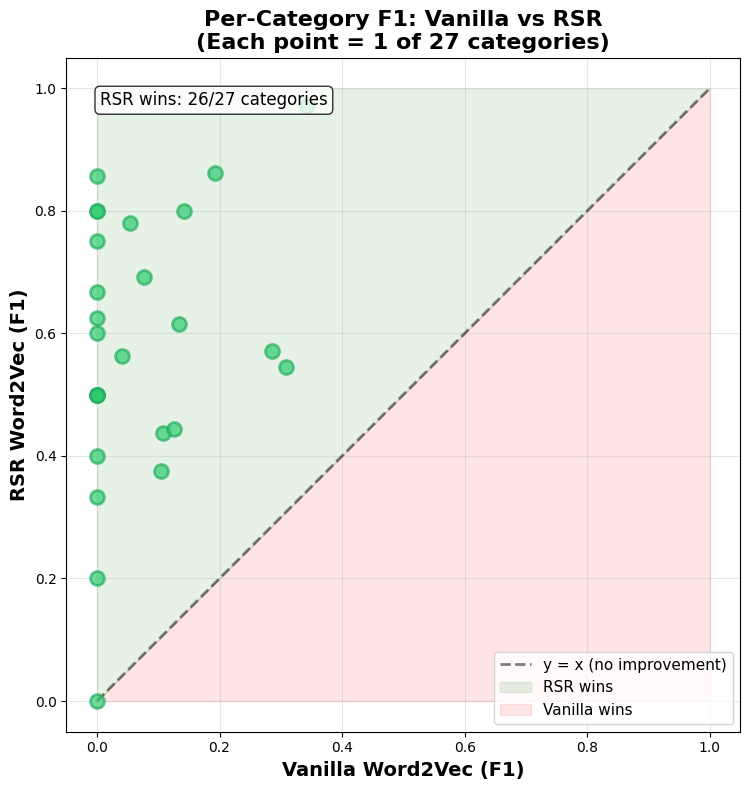


✓ Plot saved to results/category_f1_comparison.png


In [10]:
import matplotlib.pyplot as plt

# Get per-category F1 scores for both models
def get_per_category_f1(X, Y, C=1.0, test_size=0.2, random_state=42):
    """Get F1 score for each category."""
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    f1_scores = []
    valid_categories = []
    
    for f in range(Y.shape[1]):
        y = Y[:, f]
        if np.all(y == y[0]):  # Skip if all same class
            continue
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=test_size, random_state=random_state, stratify=y
        )
        clf = LogisticRegression(C=C, max_iter=1000)
        clf.fit(X_train, y_train)
        f1_scores.append(f1_score(y_test, clf.predict(X_test)))
        valid_categories.append(f)
    
    return np.array(f1_scores), valid_categories

# Get per-category scores
vanilla_f1_per_cat, valid_cats = get_per_category_f1(X_vanilla, Y)
rsr_f1_per_cat, _ = get_per_category_f1(X_rsr, Y)

# Create scatter plot
fig, ax = plt.subplots(figsize=(8, 8))

# Plot points
ax.scatter(vanilla_f1_per_cat, rsr_f1_per_cat, s=100, alpha=0.7, 
           c='#2ecc71', edgecolors='#27ae60', linewidth=2, zorder=3)

# Diagonal line (y = x)
ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=2, label='y = x (no improvement)')

# Fill regions
ax.fill_between([0, 1], [0, 1], [1, 1], alpha=0.1, color='green', label='RSR wins')
ax.fill_between([0, 1], [0, 0], [0, 1], alpha=0.1, color='red', label='Vanilla wins')

# Labels and styling
ax.set_xlabel('Vanilla Word2Vec (F1)', fontsize=14, fontweight='bold')
ax.set_ylabel('RSR Word2Vec (F1)', fontsize=14, fontweight='bold')
ax.set_title('Per-Category F1: Vanilla vs RSR\n(Each point = 1 of 27 categories)', fontsize=16, fontweight='bold')

ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
ax.legend(loc='lower right', fontsize=11)

# Add annotation
n_rsr_wins = np.sum(rsr_f1_per_cat > vanilla_f1_per_cat)
n_total = len(vanilla_f1_per_cat)
ax.text(0.05, 0.95, f'RSR wins: {n_rsr_wins}/{n_total} categories', 
        transform=ax.transAxes, fontsize=12, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
#plt.savefig('results/category_f1_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Plot saved to results/category_f1_comparison.png")


## Bonus: Nearest Neighbor Analysis

In [11]:
from numpy.linalg import norm

def cosine_sim(a, b):
    return float(np.dot(a, b) / (norm(a) * norm(b) + 1e-8))

def nearest_neighbors(word, embeddings_dict, k=5):
    if word not in embeddings_dict:
        return []
    vec = embeddings_dict[word]
    sims = [(w, cosine_sim(vec, v)) for w, v in embeddings_dict.items() if w != word]
    return sorted(sims, key=lambda x: x[1], reverse=True)[:k]

# Create word -> embedding dicts
vanilla_dict = {w: X_vanilla[i] for i, w in enumerate(valid_concepts)}
rsr_dict = {w: X_rsr[i] for i, w in enumerate(valid_concepts)}

# Compare nearest neighbors
test_words = ["cat", "dog", "car", "hammer", "apple"]

print("\n" + "="*70)
print("NEAREST NEIGHBOR COMPARISON")
print("="*70 + "\n")

for word in test_words:
    if word not in vanilla_dict:
        continue
    print(f"=== '{word}' ===")
    print("VANILLA:", [w for w, _ in nearest_neighbors(word, vanilla_dict, 5)])
    print("RSR:    ", [w for w, _ in nearest_neighbors(word, rsr_dict, 5)])
    print()


NEAREST NEIGHBOR COMPARISON

=== 'cat' ===
VANILLA: ['bubble', 'bubble_wrap', 'garlic', 'eel', 'kangaroo']
RSR:     ['puppy', 'chihuahua', 'dog', 'piglet', 'kitten']

=== 'dog' ===
VANILLA: ['ostrich', 'cat', 'pony', 'shorts', 'deer']
RSR:     ['rabbit', 'tiger', 'elephant', 'cat', 'hedgehog']

=== 'car' ===
VANILLA: ['car_door', 'car_seat', 'aircraft_carrier', 'sprinkler', 'engine']
RSR:     ['car_door', 'car_seat', 'bus', 'minivan', 'camper']

=== 'hammer' ===
VANILLA: ['chip', 'patch', 'toe', 'potato', 'grate']
RSR:     ['chisel', 'screwdriver', 'nutcracker', 'saw', 'trowel']

=== 'apple' ===
VANILLA: ['apple_tree', 'frame', 'sprinkler', 'paint', 'garbage']
RSR:     ['apple_tree', 'peach', 'pumpkin', 'pea', 'mulberry']



## Save Models

In [12]:
# Save both models for later use
import os
os.makedirs("results", exist_ok=True)

torch.save({
    'model_state_dict': vanilla_model.state_dict(),
    'vocab_size': vocab_size,
    'embedding_dim': EMBEDDING_DIM,
    'word2idx': word2idx,
    'idx2word': idx2word,
}, "results/vanilla_word2vec.pt")

torch.save({
    'model_state_dict': rsr_model.state_dict(),
    'vocab_size': vocab_size,
    'embedding_dim': EMBEDDING_DIM,
    'word2idx': word2idx,
    'idx2word': idx2word,
}, "results/rsr_word2vec.pt")

print("✓ Models saved to results/")

✓ Models saved to results/
